<a href="https://colab.research.google.com/github/Anna-Prilutsky/ait-deep-learning/blob/main/Anna_Prilutsky_AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [60]:
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import io

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD


In [5]:
!wget https://www.gutenberg.org/files/1514/1514-0.txt https://www.gutenberg.org/cache/epub/64317/pg64317.txt

--2023-04-17 18:34:21--  https://www.gutenberg.org/files/1514/1514-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120868 (118K) [text/plain]
Saving to: ‘1514-0.txt’

1514-0.txt          100%[===================>] 118.04K   595KB/s    in 0.2s    

2023-04-17 18:34:22 (595 KB/s) - ‘1514-0.txt’ saved [120868/120868]

--2023-04-17 18:34:22--  https://www.gutenberg.org/cache/epub/64317/pg64317.txt
Reusing existing connection to www.gutenberg.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 306227 (299K) [text/plain]
Saving to: ‘pg64317.txt’

pg64317.txt         100%[===================>] 299.05K  --.-KB/s    in 0.07s   

2023-04-17 18:34:22 (4.39 MB/s) - ‘pg64317.txt’ saved [306227/306227]

FINISHED --2023-04-17 18:34:22--
Total wall clock time: 1.3s
Downloaded: 2 files, 417K in 0.3

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [24]:
book1 = "/content/1514-0.txt"
book2 = "/content/pg64317.txt" 
file1 = open(book1, mode='r', encoding='utf-8-sig')
file2 = open(book2, mode='r', encoding='utf-8-sig')
book1Content = file1.read() #string
book2Content = file2.read() #string



## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

Character Length of Shakespeare's text: 116065
Character Length of Fitzgeralds text: 289901


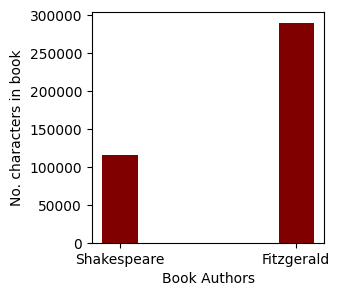

63


In [21]:
print("Character Length of Shakespeare's text: " + str(len(book1Content)))
print("Character Length of Fitzgeralds text: " + str(len(book2Content)))

data = {'Shakespeare': len(book1Content), 'Fitzgerald':len(book2Content)}
courses = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (3, 3))
plt.bar(courses, values, color ='maroon',
        width = 0.2)
plt.xlabel("Book Authors")
plt.ylabel("No. characters in book")
plt.show()

alphabet_length1= len(set(str.lower(book1Content)))
print(alphabet_length1)

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [49]:

def createEncoding(book):
  sequence_length = 60
  alphabet_length = 26     #Just looking at words only!
  listA = [*(str.lower(book))]
  lenA = len(book)

  arrA = np.zeros((0,sequence_length,alphabet_length))
  
  i = 0
  count = 0
  while (True):
    newRow = np.zeros((sequence_length, alphabet_length))
    for j in range(sequence_length):
      if (i >= lenA):
      # still add existing string
        arrA = np.r_[arrA,[newRow]]
        print(count)
        return arrA
      char = listA[i]
      index = ord(char) - 97
      i = i+1
      if index < 0 or index >= alphabet_length:
        continue
      else:
        count = count + 1
      newRow[j][index] = 1
    arrA = np.r_[arrA,[newRow]]
#######

arr1 = createEncoding(book1Content)
arr2 = createEncoding(book2Content)

print(np.shape(arr1)) 
print(np.shape(arr2)) 
    


#3D NumpPy Array: (batch, sequence_length, alphabet_length)

#Convert string into array w. 60 characters long.. 
#Text of length 60 characters per author.

87646
221798
(1935, 60, 26)
(4832, 60, 26)


## Data splitting
Split the data into train, validate and test sets. Make 

In [65]:
# Extract equal parts of both texts (1200*60 characters from each from the middle of the text)

min = 200
mid = int(1200 * 0.7 + 200)
max = 1400

text1_train_X = arr1[min:mid, :, :]
text2_train_X = arr2[min:mid, :, :]
text1_test_X = arr1[mid:max, :, :]
text2_test_X = arr2[mid:max, :, :]

X_train = np.concatenate((text1_train_X, text2_train_X), axis=0)
X_test = np.concatenate((text1_test_X, text2_test_X), axis=0)

Y_train = np.zeros((int(2400*0.7), 2))
Y_test = np.zeros((int(2400*0.3), 2))
Y_train[0:(int(2400*0.7*0.5)), 0] = 1
Y_train[int(2400*0.7*0.5):int(2400*0.7), 1] = 1
Y_test[0:(int(2400*0.3*0.5)), 0] = 1
Y_test[int(2400*0.3*0.5):int(2400*0.3), 1] = 1

#Shuffle the Arrays..
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_test))
print(np.shape(Y_test))




(1680, 60, 26)
(1680, 2)
(720, 60, 26)
(720, 2)


## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [80]:
nb_filter       = 42   # number of filter/kernels in the convolutional layers (26?)
filter_length   = 4  # length of the filter/kernel in the convolutional layers
window_size     = X_train.shape[1] # the window size defined by the dataset
nb_features     = X_train.shape[2] # the number of features of the input data
nb_outputs      = Y_train.shape[1] # the number of outputs (defined by the target data)

model = Sequential()
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', kernel_initializer='glorot_uniform', input_shape=(window_size, nb_features)))
model.add(MaxPooling1D())
model.add(Dropout(0.5))
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling1D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_outputs, activation='softmax'))





## Model training
Train the model and apply early stopping.

In [81]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights= True)
model.fit(X_train, Y_train, 
          epochs=128, batch_size=100, 
          validation_split=0.2, # don't change the validation split
          callbacks=[es],
          verbose=2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 57, 42)            4410      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 28, 42)           0         
 1D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 28, 42)            0         
                                                                 
 conv1d_10 (Conv1D)          (None, 25, 42)            7098      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 12, 42)           0         
 g1D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 12, 42)           

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [82]:
eval = model.evaluate(X_test,Y_test)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

23/23 [==============================] - 0s 6ms/step - loss: 0.3762 - accuracy: 0.8278
Test loss: 0.37618881464004517
Test accuracy: 0.8277778029441833


## Confusion matrix
Calculate and display the confusion matrix.

23/23 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       360
           1       0.79      0.89      0.84       360

    accuracy                           0.83       720
   macro avg       0.83      0.83      0.83       720
weighted avg       0.83      0.83      0.83       720



<Axes: >

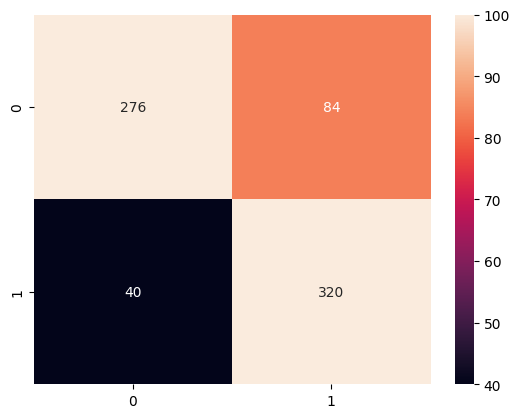

In [83]:
from sklearn.metrics import confusion_matrix, classification_report
preds = model.predict(X_test)
print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)